# Thermal Transport from NEMD
# 1. Introduction
- In this tutorial, we use the NEMD method to study heat transport in graphene at 300 K and zero pressure. Here we consider the ballistic regime. The diffusive regime can be found in the HNEMD example. The spectral decomposition method as described in [[Fan 2019]](https://doi.org/10.1103/PhysRevB.99.064308) is used here.

### Importing Relevant Functions
- The inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.

In [1]:
from pylab import *
from ase.io import write
from thermo.gpumd.preproc import add_group_by_position
from thermo.gpumd.data import load_shc,load_compute
from ase.build import graphene_nanoribbon

# 2. Preparing the Inputs
- We consider a graphene sheet of size of about 25 nm x 43 nm (40400 atoms). The transport is in the $y$ direction. We divide the length in the $y$ direction into 9 groups. Group 0 (a small one) will be fixed. Group 1 (about 9 nm long) will act as a heat source and group 8 (about 9 nm long) will act as a sink. The remaining middle part is evenly divided into a few groups (group 2 to group 7).
- We use a Tersoff potential [[Tersoff 1989]](https://doi.org/10.1103/PhysRevB.39.5566) parameterized by Lindsay *et al.* [[Lindsay 2010]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.205441).

## Generate the  [model.xyz](https://gpumd.zheyongfan.org/index.php/The_model.xyz_input_file) file:

In [2]:
gnr = graphene_nanoribbon(100, 101, type='armchair', sheet=True, vacuum=3.35/2)
# Rotate to match example
gnr.euler_rotate(theta=90)
l = gnr.cell.lengths()
gnr.cell = gnr.cell.new((l[0], l[2], l[1]))
l = l[2]
gnr.center()
gnr.pbc = [True, True, False]
gnr

Atoms(symbols='C40400', pbc=[True, True, False], cell=[245.95121467478057, 430.26, 3.35])

#### Add Groups for NEMD

In [3]:
split = array([l/100] + [l/5] + [l/10]*6)-0.4
split = [0] + list(cumsum(split)) + [l]
print(split)

[0, 3.9026, 89.5546, 132.1806, 174.8066, 217.4326, 260.0586, 302.6846, 345.31059999999997, 430.26]


In [4]:
ncounts = add_group_by_position(split, gnr, direction='y')
print("Atoms per group:", ncounts)
print("Total atoms:", sum(ncounts))

Atoms per group: [400, 8000, 4000, 4000, 4000, 4000, 4000, 4000, 8000]
Total atoms: 40400


In [7]:
write("model.xyz", gnr, write_info = False) 

with open("model.xyz", "r") as fin:
    lines = fin.readlines() 

lines[1] = lines[1].split("R:3")[0] + "R:3:group:I:1" + lines[1].split("R:3")[1]
for i in range(len(lines) - 2):
    group_id = gnr.info[i]["groups"][0]
    lines[i + 2] = lines[i + 2][:-2] + f"\t{group_id}\n"
    
with open("model.xyz", "w") as fout:
    fout.writelines(lines)


## The <code>run.in</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential    ../../../../potentials/tersoff/Graphene_Lindsay_2010_modified.txt
velocity     300

ensemble     nvt_ber 300 300 100
fix          0
time_step    1 
dump_thermo  1000        
run          100000

ensemble     heat_lan 300 100 10 1 8 
fix          0
compute      0 10 100 temperature
compute_shc  2 250 1 1000 400.0 group 0 4
run          1000000
```

- The first line uses the [potential](https://gpumd.zheyongfan.org/index.php/The_potential_keyword) keyword to define the potential to be used, which is specified in the file [Graphene_Lindsay_2010_modified.txt](https://github.com/brucefan1983/GPUMD/blob/master/potentials/tersoff/Graphene_Lindsay_2010_modified.txt).

- The second line uses the [velocity](https://gpumd.zheyongfan.org/index.php/The_velocity_keyword) keyword and sets the velocities to be initialized with a temperature of 300 K. 

- There are two runs. The first [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) serves as the equilibration stage.
  - Here, the NVT [ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword) (the Berendsen thermostat) is used. The target temperature is 300 K and the coupling constant is 100 time steps for the thermostat. 
  - The [time_step](https://gpumd.zheyongfan.org/index.php/The_time_step_keyword) for integration is 1 fs. 
  - Atoms in group 0 will be fixed. 
  - The thermodynamic quantities will be output every 1000 steps. 
  - There are $10^5$ steps (100 ps) for this run. 
- The second [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword) is for production. 
  - Here, two local Langevin thermostats ([ensemble](https://gpumd.zheyongfan.org/index.php/The_ensemble_keyword)) are applied to generate a nonequilibrium heat current. The time parameter in the Langevin thermostats is 0.1 ps (100 time steps). The target temperature of the heat source is $300+10=310$ K and the target temperature of the heat sink is $300-10=290$ K. Atoms in group 1 are in the heat source region and atoms in group 8 are in the heat sink region.
  - Atoms in group 0 will be fixed. 
  - The [compute](https://gpumd.zheyongfan.org/index.php/The_compute_keyword) is used to compute the group temperatures and energy transfer rate. Here, grouping method 0 is used, and the relevant data are sampled every 10 time steps and averaged for every 100 data points before written out. 
  - The line with the [compute_shc](https://gpumd.zheyongfan.org/index.php/The_compute_shc_keyword) keyword is used to compute the spectral heat current (SHC). The SHC will be calculated for group <code>4</code> in grouping method <code>0</code>. The relevant data will be sampled every 2 steps and the maximum correlation time is $250 \times 2 \times 1~{\rm fs} = 500~{\rm fs}$. The transport directions is <code>1</code> ($y$ direction). The number of frequency points is 1000 and the maximum angular frequncy is 400 THz.
  - There are $10^6$ steps (1 ns) in the production [run](https://gpumd.zheyongfan.org/index.php/The_run_keyword). This is just an example. To get more accurate results, we suggest you use $10^7$ steps (10 ns).

# 3. Results and Discussion
### Computation Time
- Using a GeForce RTX 2080 Ti GPU, the NEMD simulation takes about 15 minutes.

### Figure Properties

In [8]:
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)

def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(axis='both', direction='in', right=True, top=True)

## Plot NEMD Results
 - The [compute.out](https://gpumd.zheyongfan.org/index.php/The_compute_keyword) output file is loaded and processed to create the following figure.

In [9]:
compute = load_compute(['T'])
compute.keys()

dict_keys(['Ein', 'Eout', 'm', 'T'])

In [10]:
T = compute['T']
Ein = compute['Ein']
Eout = compute['Eout']
ndata = T.shape[0]
temp_ave = mean(T[int(ndata/2)+1:, 1:], axis=0)

dt = 0.001  # ps 
Ns = 1000  # Sample interval
t = dt*np.arange(1,ndata+1) * Ns/1000  # ns

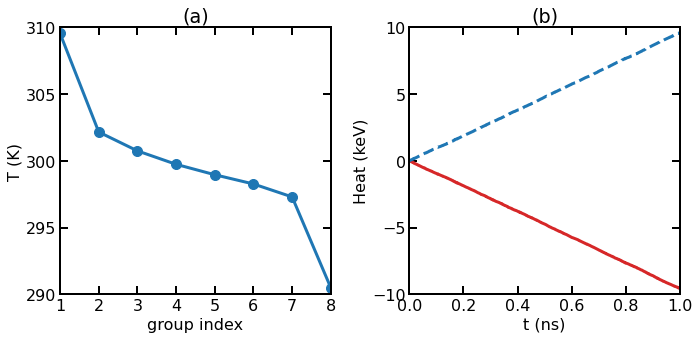

In [11]:
figure(figsize=(10,5))
subplot(1,2,1)
set_fig_properties([gca()])
group_idx = range(1,9)
plot(group_idx, temp_ave,linewidth=3,marker='o',markersize=10)
xlim([1, 8])
gca().set_xticks(group_idx)
ylim([290, 310])
gca().set_yticks(range(290,311,5))
xlabel('group index')
ylabel('T (K)')
title('(a)')

subplot(1,2,2)
set_fig_properties([gca()])
plot(t, Ein/1000, 'C3', linewidth=3)
plot(t, Eout/1000, 'C0', linewidth=3, linestyle='--' )
xlim([0, 1])
gca().set_xticks(linspace(0,1,6))
ylim([-10, 10])
gca().set_yticks(range(-10,11,5))
xlabel('t (ns)')
ylabel('Heat (keV)')
title('(b)')
tight_layout()
show()

**(a)** Temperature profile in the NEMD simulation. **(b)** Energies accumulated in the thermostats.

- The figure above shows the temperature profile and the energies accumulated in the thermostats. The energy of the thermostat coupling to the heat source region is decreasing, because energy is transferred from the thermostat to the atoms in the source region. The energy of the thermostat coupling to the heat sink region is increasing, because energy is transferred from the atoms in the sink region to the thermostat. The absolute values of the slopes of the lines in **(b)** should be the same; otherwise it means energy is not conserved. The absolute slope is the energy transfer rate $Q=dE/dt$.
- The thermal conductance in this system can be calculated as
$$
G = \frac{Q/S}{\Delta T}
$$
where $S$ is the cross-sectional area and $\Delta T$ is the temperature difference, which is 19 K here (slightly smaller than the target value of 20 K). The calculated thermal conductance is about 10 GW m<sup>-2</sup> K<sup>-1</sup>. This is the classical value.

In [12]:
deltaT = temp_ave[0] - temp_ave[-1]  # [K]
deltaT

19.04638256513016

In [13]:
Q1 = (Ein[int(ndata/2)] - Ein[-1])/(ndata/2)/dt/Ns
Q2 = (Eout[-1] - Eout[int(ndata/2)])/(ndata/2)/dt/Ns
Q = mean([Q1, Q1])  # [eV/ps]
Q

9.635182

In [14]:
l = gnr.cell.lengths()
A = l[0]*l[2]/100  # [nm2]
G = 160*Q/deltaT/A  # [GW/m2/K]
G

9.82366678786541

## Plot Spectral Heat Current Results
 - The [shc.out](https://gpumd.zheyongfan.org/index.php/The_shc.out_output_file) output file is loaded and processed to create the following figure.

In [15]:
shc = load_shc(250, 1000)['run0']
shc.keys()

dict_keys(['t', 'Ki', 'Ko', 'nu', 'jwi', 'jwo'])

In [16]:
Ly = split[5]-split[4]
Lx, Lz = l[0], l[2]
V = Lx*Ly*Lz
Gc = 1.6e4*(shc['jwi']+shc['jwo'])/V/deltaT

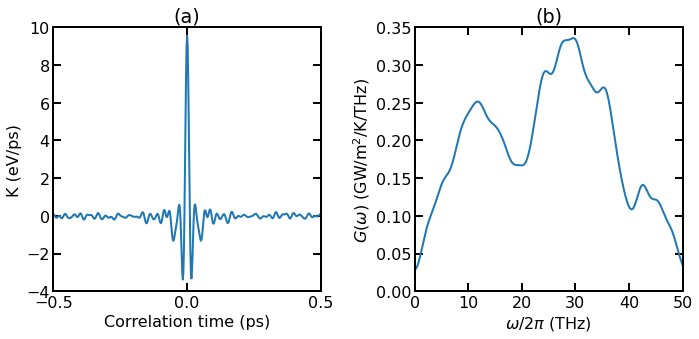

In [17]:
figure(figsize=(10,5))
subplot(1,2,1)
set_fig_properties([gca()])
plot(shc['t'], (shc['Ki']+shc['Ko'])/Ly, linewidth=2)
xlim([-0.5, 0.5])
gca().set_xticks([-0.5, 0, 0.5])
ylim([-4, 10])
gca().set_yticks(range(-4,11,2))
ylabel('K (eV/ps)')
xlabel('Correlation time (ps)')
title('(a)')

subplot(1,2,2)
set_fig_properties([gca()])
plot(shc['nu'], Gc, linewidth=2)
xlim([0, 50])
gca().set_xticks(range(0,51,10))
ylim([0, 0.35])
gca().set_yticks(linspace(0,0.35,8))
ylabel(r'$G$($\omega$) (GW/m$^2$/K/THz)')
xlabel(r'$\omega$/2$\pi$ (THz)')
title('(b)')
tight_layout()
show()

**(a)** Virial-velocity correlation function. **(b)** Spectral thermal conductance.

- The figure above shows the virial-velocity correlation function $K(t)$ and the spectral thermal conductance $G(\omega)$. See [Theoretical formulations](https://gpumd.zheyongfan.org/index.php/Theoretical_formulations) for the definitions of these quantities. Using the spectral thermal conductance, one can perform quantum correction, see [[Li 2019]](https://doi.org/10.1063/1.5132543).

In [18]:
np.save('../diffusive/Gc.npy', Gc)

# 4. References
- [Fan 2019] Zheyong Fan, Haikuan Dong, Ari Harju, and Tapio Ala-Nissila, [Homogeneous nonequilibrium molecular dynamics method for heat transport and spectral decomposition with many-body potentials](https://doi.org/10.1103/PhysRevB.99.064308), Phys. Rev. B **99**, 064308 (2019).
- [Li 2019] Zhen Li, Shiyun Xiong, Charles Sievers, Yue Hu, Zheyong Fan, Ning Wei, Hua Bao, Shunda Chen, Davide Donadio, and Tapio Ala-Nissila, [Influence of Thermostatting on Nonequilibrium Molecular Dynamics Simulations of Heat Conduction in Solids](https://doi.org/10.1063/1.5132543), J. Chem. Phys. **151**, 234105 (2019).
- [Lindsay 2010] L. Lindsay and D.A. Broido, [Optimized Tersoff and Brenner emperical potential parameters for lattice dynamics and phonon thermal transport in carbon nanotubes and graphene](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B, **81**, 205441 (2010).
- [Tersoff 1989] J. Tersoff, [Modeling solid-state chemistry: Interatomic potentials for multicomponent systems](https://doi.org/10.1103/PhysRevB.39.5566), Phys. Rev. B 39, 5566(R) (1989).